# Dogs vs Cats



## Create validation data set

In [1]:
import os
import shutil

validation_dir = "data/validation"
train_dir = "data/train"
test_dir = "data/test"

if os.path.exists(validation_dir):
    print("Validation has been finished, skip.")
else:
    print("Create validation and load train data.")

    os.makedirs(os.path.join(train_dir, "cats"))
    os.makedirs(os.path.join(train_dir, "dogs"))
    os.makedirs(os.path.join(validation_dir, "cats"))
    os.makedirs(os.path.join(validation_dir, "dogs"))

    filenames = os.listdir(train_dir)
    file_num = len(filenames)
    # file_num / 2 == cat_num or dog_num
    train_num = int(file_num/2/5*4)
    
    src_dir = ""
    dst_dir = ""

    for filename in filenames:
        splits = filename.split('.')
        if len(splits) != 3:
            continue
        
        src_dir = os.path.join(train_dir, filename)
        dst_dir = ""
        
        index = int(splits[1])
        if index < train_num:
            # is train data
            dst_dir = train_dir
        else:
            dst_dir = validation_dir
            index -= train_num
        
        dst_dir = os.path.join(dst_dir, splits[0]+"s", "{}.{}".format(index, splits[2]))
        
        shutil.move(src_dir, dst_dir)
    print("Creating done.")
        


Validation has been finished, skip.


## Preprocess image and load data set


In [2]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


def get_loader(batch_size):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.ColorJitter(),
        transforms.RandomCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(128),
        transforms.ToTensor()
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform)
    validation_dataset = datasets.ImageFolder(validation_dir, transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, validation_loader

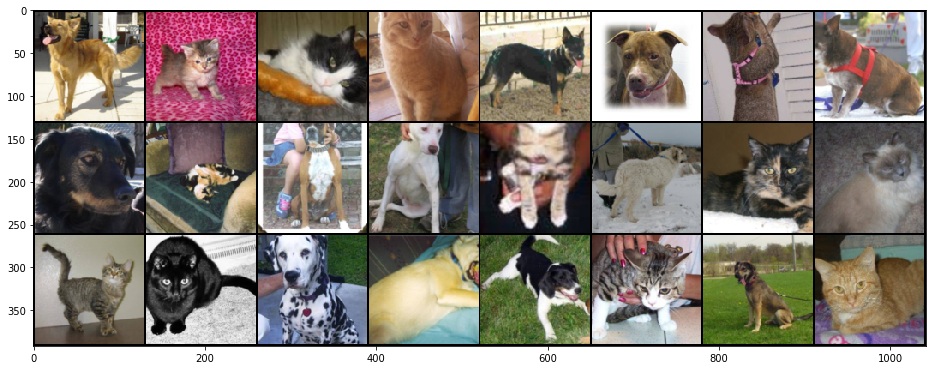

In [3]:
# show data set
import matplotlib.pyplot as plt
import torchvision
import numpy as np
%matplotlib inline

train_loader, _ = get_loader(40)
imgs, labels = iter(train_loader).next()
plt.figure(figsize=(16, 24))
grid_imgs = torchvision.utils.make_grid(imgs[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1, 2, 0)))

## Build Model

1. 
```
Class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

参数：
    in_channels(int) // 输入信号的通道
    out_channels(int) // 卷积产生的通道
    kerner_size(int or tuple) // 卷积核的尺寸
    stride(int or tuple, optional) // 卷积步长
    padding(int or tuple, optional) // 输入的每一条边补充0的层数
    dilation(int or tuple, optional) // 卷积核元素之间的间距
    groups(int, optional) // 从输入通道到输出通道的阻塞连接数
    bias(bool, optional) // 如果bias=True，添加偏置
```
2. 
```
Class torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

参数：
    kernel_size(int or tuple) // max pooling窗口大小
    stride(int or tuple, optional) // max pooling窗口移动的步长，默认值是kernel_size
    padding(int or tuple, optional) // 输入的每一条边补充0的层数
    dilation(int or tuple, optional) //一个控制窗口中元素步幅的参数
    return_indices // 如果等于True，会返回输出最大值的序号，对于上采样操作会有帮助
    ceil_mode // 如果等于True，计算输出信号大小的时候，会使用向上取整，代替默认的向下取整的操作
```
3. 
```
Class torch.nn.Linear(in_features, out_features, bias=True)

参数：
    in_features // 每个输入样本的大小
    out_features // 每个输出样本的大小
    bias // 若设置为False，这层不会学习偏置。默认值：True
```

In [4]:
from torch import nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def  __init__ (self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.max_pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(57600, 2048)
        self.fc2 = nn.Linear(2048, 256)
        self.fc3 = nn.Linear(256, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

## Train model

In [5]:
from torch.autograd import Variable
import torch
import torch.nn.functional as F

cirt = torch.nn.CrossEntropyLoss()

# 之后让模型逐条读取训练集中的数据，进行训练：
def train(model, train_loader, validation_loader, optimizer, epochs):

    loss_list = []
    acc_list = []

    for epoch in range(epochs):
        running_loss = 0.0

        train_correct = torch.zeros(1).squeeze().cuda()
        train_total = torch.zeros(1).squeeze().cuda()

        for batch_idx, (data, target) in enumerate(train_loader, 0):
            
            inputs = Variable(data.cuda())
            labels = Variable(target.cuda())
            
            optimizer.zero_grad()
            
            outputs = model(inputs)

            _, prediction = torch.max(outputs.data, 1)
            # 图像分类中使用cross_entropy作为损失函数
            loss = cirt(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            train_correct += (prediction == labels.data).sum()
            train_total += target.size(0)
        
        loss_list.append(running_loss / train_total)
        acc_list.append(100 * train_correct / train_total)

        print('train %d epoch loss: %.3f  acc: %.3f ' % (epoch + 1, running_loss / train_total, 100 * train_correct / train_total))

        # 模型测试
        validation_total = 0
        validation_loss = 0.0
        validation_correct = 0

        model.eval()
        for (data, target) in validation_loader:
            inputs = Variable(data.cuda())
            labels = Variable(target.cuda())
            outputs = model(inputs)
            _, prediction = torch.max(outputs.data, 1)
            loss = cirt(outputs, labels)
            
            validation_loss += loss.item()
            validation_total += labels.size(0)
            validation_correct += (prediction == labels.data).sum()

        print('Validation  %d epoch loss: %.3f  acc: %.3f ' % (epoch + 1, validation_loss / validation_total, 100 * validation_correct / validation_total))
    
    # show
    plt.plot(loss_list, label='loss')
    plt.plot(acc_list, label='accuracy')
    plt.legend()
    plt.title('training loss and accuracy')
    plt.show()

# Main process

Start training, batch:32, learn_rate:0.0001, epoch:4
train 1 epoch loss: 0.020  acc: 64.145 
Validation  1 epoch loss: 0.018  acc: 71.000 
train 2 epoch loss: 0.017  acc: 73.150 
Validation  2 epoch loss: 0.017  acc: 72.000 
train 3 epoch loss: 0.015  acc: 76.195 
Validation  3 epoch loss: 0.015  acc: 76.000 
train 4 epoch loss: 0.015  acc: 77.485 
Validation  4 epoch loss: 0.015  acc: 77.000 


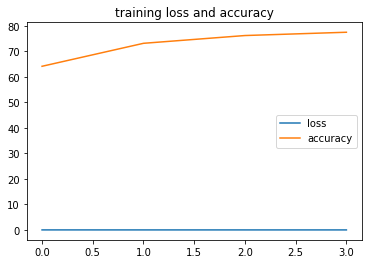

Train done.


In [6]:
import torch

torch.set_default_tensor_type(torch.FloatTensor)

batch_size = 32
learn_rate = 1e-4
epoch = 4

print("Start training, batch:{}, learn_rate:{}, epoch:{}".format(batch_size, learn_rate, epoch))

train_loader, validation_loader = get_loader(batch_size)

model = ConvNet()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
train(model, train_loader, validation_loader, optimizer, epoch)

print("Train done.")
torch.save(model, "model.pl")
